# Load Data

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mp_patches

## Get Files

In [ ]:
url = 'https://drive.google.com/file/d/1ZQdlefQ9xWj4eLWshaTloqiq63mP6zB8/view?usp=sharing'
batch_name = '151121_two_hydrophone'

In [ ]:
!ls "{batch_name}.tar.xz" 2>/dev/null || (python -m pip install gdown --upgrade > /dev/null && gdown --fuzzy "{url}")

Downloading...
From: https://drive.google.com/uc?id=1ZQdlefQ9xWj4eLWshaTloqiq63mP6zB8
To: /content/151121_two_hydrophone.tar.xz
100% 358M/358M [00:04<00:00, 85.0MB/s]


In [ ]:
!ls "{batch_name}" 2>/dev/null 1>/dev/null || tar xvf "{batch_name}.tar.xz"

151121_two_hydrophone/
151121_two_hydrophone/d065_1/
151121_two_hydrophone/d065_1/pico.npts
151121_two_hydrophone/d000_1/
151121_two_hydrophone/d000_1/pico.npts
151121_two_hydrophone/d065_2/
151121_two_hydrophone/d065_2/pico.npts
151121_two_hydrophone/README
151121_two_hydrophone/d125_1/
151121_two_hydrophone/d125_1/pico.npts
151121_two_hydrophone/d125_2/
151121_two_hydrophone/d125_2/pico.npts
151121_two_hydrophone/d000_2/
151121_two_hydrophone/d000_2/pico.npts


In [ ]:
runs = {
    0.00: ('d000_1', 'd000_2',),
    0.65: ('d065_1', 'd065_2',),
    1.25: ('d125_1', 'd125_2',),
}

In [ ]:
fs = 1e6
dt = 1.0 / fs
v_sound = 1480

## Loader

In [ ]:
import numpy as np
import struct

from scipy.signal import butter, lfilter, filtfilt, hilbert
class BP:
    def __init__(self, fs=1e6, low=30e3, high=50e3, order=5, preserve_phase=False):
        nyq = 0.5 * fs
        self.coeffs = butter(order, [low / nyq, high / nyq], btype='band')
        self.apply = filtfilt if preserve_phase else lfilter

    def __call__(self, data):
        return self.apply(*self.coeffs, data, axis=0)

class MA:
    def __init__(self, fs=1e6, dt=1e-3):
        self.n = int(fs * dt)
        self.kernel = np.ones((self.n,), dtype=np.int32) / self.n

    def __call__(self, data):
        out = np.empty_like(data)
        for i in range(data.shape[1]):
            out[:, i] = np.convolve(np.abs(data[:, i]), self.kernel, mode='same')
        return out

class Hilbert:
    def __init__(self, fs=1e6):
        pass

    def __call__(self, data):
        return np.abs(hilbert(data))

class PicoDataLoader:
    bufsize = 100000
    time_len = struct.calcsize('<d')
    time_unpack = struct.Struct('<d').unpack_from
    
    def __init__(self, filename, # filename: Union[str, path_like, File object]
                 bp_args={'fs': fs, 'low': 35e3, 'high':45e3},
                 ma_args={'fs': fs, 'dt': 6e-5}):  
        self.filename = filename
        self.file = None

        self.transformers = []
        if bp_args:
            self.transformers.append(BP(**bp_args))
        if ma_args:
            self.transformers.append(MA(**ma_args))
    
    def open(self):
        # For compatibility with tarfiles
        # See: https://github.com/numpy/numpy/issues/7989#issuecomment-340921579
        if self.file is not None:
            self.close()
        import io
        if isinstance(self.filename, io.BufferedReader):
          array_file = io.BytesIO()
          array_file.write(self.filename.read())
          array_file.seek(0)
          self.file = array_file
        else:
          self.file = open(self.filename, 'rb')
    
    def get(self):
        if self.file is None:
            raise Exception("Use ```open``` and ```close```")
        try:
            t = self.time_unpack(self.file.read(self.time_len))[0]
            arr = np.load(self.file)
            dtype = arr.dtype
            for tran in self.transformers:
                arr = tran(arr)
            return t, arr.astype(dtype)
        except ValueError:
            raise StopIteration()
        except struct.error:
            raise StopIteration()

    def close(self):
        if self.file is not None:
            self.file.close()

    def __enter__(self):
        self.open()
        return self
    def __exit__(self ,type, value, traceback):
        self.close()

In [ ]:
# import itertools
# import numpy as np


# # TODO: how to deal with multiple sets of zero crossing,
# # TODO: groupby can bre replaced my numpy indexing i think
# # notes for function def stage_1(signal, winsize_zero_cross, fs, run_plot)
# # stage 1 does the following processes:
# # 1. filter use IIR bandpass filters
# # 2. estimate the zero-crossing of the first peak in two stages
# #    first of which is approximate position where first peak crosses the threshold of 10% of signal mean
# #    second stage, wherein use curvature of the signal to estimate a more-accurate estimate of zero-crossing
# # Availible defaults           500,1e6,                    0,
# def Est_ZC_stage_1(signal, winsize, std_noise_multiplier, run_plot=False, plot_title='zero_crossing'):
#     def sum_index(index_limit, reshaped_group_results_len):
#         ind_count = 0
#         for k in range(0, index_limit):
#             ind_count = ind_count + reshaped_group_results_len[k]
#         return ind_count

#     def ZC_estimation(signal_h, noise_threshold, n_max_p):

#         # estimate out part of the signal which is > threshold
#         results = np.where(signal_h > noise_threshold, True, False)

#         # itertools groupby aims to group the array in groups of True and False
#         # where g is the groups and k is unique key/ value in each group
#         # size/ length of the groups is given by len(list(g)) and is stored as an np.array
#         group_results_len = np.array([len(list(g)) for k, g in itertools.groupby(results)])

#         # only the first value of each groups (True or False) is stored in this array - will now correspond to each group
#         # for which length are estimated previously
#         group_results_value = np.array([list(g)[0] for k, g in itertools.groupby(results)])

#         # indices & group-length wherein corresponding value in group_results_value is True
#         ind_of_group_results_value_for_trues = np.array(np.where(group_results_value == True))
#         group_len_counts_of_true = (group_results_len[ind_of_group_results_value_for_trues])

#         # indices of top n_max maximuma of group_len_counts_of_true
#         ind_n_max_group_len_counts_of_true = np.array(np.argsort(-group_len_counts_of_true))

#         # manipulations to match the shape of the arrays
#         group_len_counts_of_true = group_len_counts_of_true.T
#         ind_n_max_group_len_counts_of_true = ind_n_max_group_len_counts_of_true.T

#         # how many maxs (top-n) need to be estimated?
#         n_max = int(len(group_len_counts_of_true) * n_max_p / 100)
#         if n_max <= 2:
#             n_max = int(len(group_len_counts_of_true))

#         ind_n_max_group_len_counts_of_true = np.array(ind_n_max_group_len_counts_of_true[0:n_max])

#         # what are the values of the top-n (sorted) group-lengths of trues?
#         values_maxes_in_group_results_len = np.array((group_len_counts_of_true[ind_n_max_group_len_counts_of_true]))
#         values_maxes_in_group_results_len = np.reshape(values_maxes_in_group_results_len, (n_max, 1))

#         # manipulations to match the shape of the arrays
#         reshaped_group_results_len = np.reshape(group_results_len, (len(group_results_len), 1))

#         # elementwise comparison of the arrays to estimate the starting indices of the n_max groups of True:
#         # comparison with the entire (true-false) list
#         ind_of_max_in_group_results_len = np.array(np.where(np.in1d(reshaped_group_results_len,
#                                                                     values_maxes_in_group_results_len)))

#         index_max_counts_of_true = np.zeros((len(ind_of_max_in_group_results_len), 1))
#         for i in range(len(ind_of_max_in_group_results_len)):
#             try:
#                 index_max_counts_of_true[i] = sum_index(ind_of_max_in_group_results_len[i, 0],
#                                                         reshaped_group_results_len) + 1
#             except:
#                 index_max_counts_of_true[i] = 0
#                 break

#         Q_zero_cross_index = (np.min(index_max_counts_of_true[:, 0])).astype(int)

#         return Q_zero_cross_index

#     def plot_ZC(signal_h, Q_zero_cross_index, plot_title, winsize):
#         import matplotlib.pyplot as plt
#         from matplotlib.patches import Rectangle
#         index = Q_zero_cross_index
#         fig, axs = plt.subplots(1, figsize=(10,4))
#         fig.suptitle(plot_title)
#         axs.plot(signal_h, label='bandpass')
#         axs.plot(np.repeat(0, len(signal_h)), 'k--', label='zero level')
#         axs.plot(np.repeat(noise_threshold_1, len(signal_h)), 'r--', label='noise_threshold_1')
#         axs.plot(np.repeat(noise_threshold_2, len(signal_h)), 'b--', label='noise_threshold_2')
#         axs.plot(index, signal_h[index], 'o')
#         rect = Rectangle((index, 0), winsize * 2, np.max(signal_h) / 2, linewidth=3, edgecolor='r', facecolor='none')
#         axs.add_patch(rect)
#         axs.legend()

#     # filter first and then, normalise the signal for further processing
#     # estimate the envelope of the rectified signal using the hilbert transform
#     # estimate threshold
#     # threshold = (np.mean(signal))
#     # signal_noise_h = np.where(signal > threshold, 0, signal)
#     # noise_threshold_1 = np.mean(signal_noise_h) + std_noise_multiplier * np.std(signal_noise_h)
#     noise_threshold_1 = 700
#     # print('noise_threshold_1', noise_threshold_1)

#     # first iteration
#     n_max_p = 5
#     init_est_ZC_index = ZC_estimation(signal, noise_threshold_1, n_max_p)
#     # print(f'init_est_ZC_index - {plot_title}', init_est_ZC_index)

#     # attempt to check the samples in the neighbourhood
#     hori_check_indices = np.linspace(max(init_est_ZC_index - winsize,0), min(init_est_ZC_index + winsize,signal.shape[0] - 1), winsize * 2, dtype=int)
#     if np.all(signal[hori_check_indices] < 10 * noise_threshold_1):
#         init_est_ZC_index = ZC_estimation(signal, noise_threshold_1 * 2, n_max_p)

#     # attempt to check the samples in the neighbourhood by selecting a window with elevated threshold
#     noise_threshold_2 = noise_threshold_1 * 1.25
#     # print('noise_threshold_2', noise_threshold_2)
#     second_est_ZC_index = 0
#     if signal[init_est_ZC_index] >= 3 * noise_threshold_1:
#         # second iteration
#         n_max_p = 50
#         sub_signal = signal[init_est_ZC_index - winsize: init_est_ZC_index + winsize]
#         ZC_subsignal = ZC_estimation(sub_signal, noise_threshold_2, n_max_p)
#         # print(f'ZC_subsignal - {plot_title}', ZC_subsignal)
#         second_est_ZC_index = init_est_ZC_index + (ZC_subsignal - winsize)
#         # print(f'second_est_ZC_index - {plot_title}', second_est_ZC_index)

#     if second_est_ZC_index != 0:
#         ZC_index = second_est_ZC_index
#     else:
#         ZC_index = init_est_ZC_index

#     if run_plot:
#         plot_ZC(signal, ZC_index, plot_title, winsize)

#     return ZC_index


In [ ]:
import itertools
import numpy as np


# TODO: how to deal with multiple sets of zero crossing,
# TODO: groupby can bre replaced my numpy indexing i think
# notes for function def stage_1(signal, winsize_zero_cross, fs, run_plot)
# stage 1 does the following processes:
# 1. filter use IIR bandpass filters
# 2. estimate the zero-crossing of the first peak in two stages
#    first of which is approximate position where first peak crosses the threshold of 10% of signal mean
#    second stage, wherein use curvature of the signal to estimate a more-accurate estimate of zero-crossing
# Availible defaults           500,1e6,                    0,
def Est_ZC_stage_1(signal, winsize, std_noise_multiplier, run_plot=False, plot_title='zero_crossing'):
    def sum_index(index_limit, reshaped_group_results_len):
        ind_count = 0
        for k in range(0, index_limit):
            ind_count = ind_count + reshaped_group_results_len[k]
        return ind_count

    def ZC_estimation(signal_h, noise_threshold, n_max_p):

        # estimate out part of the signal which is > threshold
        results = np.where(signal_h > noise_threshold, True, False)

        # itertools groupby aims to group the array in groups of True and False
        # where g is the groups and k is unique key/ value in each group
        # size/ length of the groups is given by len(list(g)) and is stored as an np.array
        group_results_len = np.array([len(list(g)) for k, g in itertools.groupby(results)])

        # only the first value of each groups (True or False) is stored in this array - will now correspond to each group
        # for which length are estimated previously
        group_results_value = np.array([list(g)[0] for k, g in itertools.groupby(results)])

        # indices & group-length wherein corresponding value in group_results_value is True
        ind_of_group_results_value_for_trues = np.array(np.where(group_results_value == True))
        group_len_counts_of_true = (group_results_len[ind_of_group_results_value_for_trues])

        # indices of top n_max maximuma of group_len_counts_of_true
        ind_n_max_group_len_counts_of_true = np.array(np.argsort(-group_len_counts_of_true))

        # manipulations to match the shape of the arrays
        group_len_counts_of_true = group_len_counts_of_true.T
        ind_n_max_group_len_counts_of_true = ind_n_max_group_len_counts_of_true.T

        # how many maxs (top-n) need to be estimated?
        n_max = int(len(group_len_counts_of_true) * n_max_p / 100)
        if n_max <= 2:
            n_max = int(len(group_len_counts_of_true))

        ind_n_max_group_len_counts_of_true = np.array(ind_n_max_group_len_counts_of_true[0:n_max])

        # what are the values of the top-n (sorted) group-lengths of trues?
        values_maxes_in_group_results_len = np.array((group_len_counts_of_true[ind_n_max_group_len_counts_of_true]))
        values_maxes_in_group_results_len = np.reshape(values_maxes_in_group_results_len, (n_max, 1))

        # manipulations to match the shape of the arrays
        reshaped_group_results_len = np.reshape(group_results_len, (len(group_results_len), 1))

        # elementwise comparison of the arrays to estimate the starting indices of the n_max groups of True:
        # comparison with the entire (true-false) list
        ind_of_max_in_group_results_len = np.array(np.where(np.in1d(reshaped_group_results_len,
                                                                    values_maxes_in_group_results_len)))

        index_max_counts_of_true = np.zeros((len(ind_of_max_in_group_results_len), 1))
        for i in range(len(ind_of_max_in_group_results_len)):
            try:
                index_max_counts_of_true[i] = sum_index(ind_of_max_in_group_results_len[i, 0],
                                                        reshaped_group_results_len) + 1
            except:
                index_max_counts_of_true[i] = 0
                break

        Q_zero_cross_index = (np.min(index_max_counts_of_true[:, 0])).astype(int)

        return Q_zero_cross_index

    def plot_ZC(signal_h, Q_zero_cross_index, plot_title, winsize):
        import matplotlib.pyplot as plt
        from matplotlib.patches import Rectangle
        index = Q_zero_cross_index
        fig, axs = plt.subplots(1, figsize=(10,4))
        fig.suptitle(plot_title)
        axs.plot(signal_h, label='bandpass')
        axs.plot(np.repeat(0, len(signal_h)), 'k--', label='zero level')
        axs.plot(np.repeat(noise_threshold_1, len(signal_h)), 'r--', label='noise_threshold_1')
        axs.plot(np.repeat(noise_threshold_2, len(signal_h)), 'b--', label='noise_threshold_2')
        axs.plot(index, signal_h[index], 'o')
        rect = Rectangle((index, 0), winsize * 2, np.max(signal_h) / 2, linewidth=3, edgecolor='r', facecolor='none')
        axs.add_patch(rect)
        axs.legend()

    # filter first and then, normalise the signal for further processing
    # estimate the envelope of the rectified signal using the hilbert transform
    # estimate threshold
    threshold = (np.mean(signal))
    signal_noise_h = np.where(signal > threshold, 0, signal)
    noise_threshold_1 = np.mean(signal_noise_h) + std_noise_multiplier * np.std(signal_noise_h)
    noise_threshold_1 = 200
    # print('noise_threshold_1', noise_threshold_1)

    # first iteration
    n_max_p = 5
    init_est_ZC_index = ZC_estimation(signal, noise_threshold_1, n_max_p)
    # print(f'init_est_ZC_index - {plot_title}', init_est_ZC_index)

    # attempt to check the samples in the neighbourhood
    hori_check_indices = np.linspace(max(init_est_ZC_index - winsize,0), min(init_est_ZC_index + winsize,signal.shape[0] - 1), winsize * 2, dtype=int)
    if np.all(signal[hori_check_indices] < 10 * noise_threshold_1):
        init_est_ZC_index = ZC_estimation(signal, noise_threshold_1 * 2, n_max_p)

    # attempt to check the samples in the neighbourhood by selecting a window with elevated threshold
    noise_threshold_2 = noise_threshold_1 * 1.25
    # print('noise_threshold_2', noise_threshold_2)
    second_est_ZC_index = 0
    if signal[init_est_ZC_index] >= 3 * noise_threshold_1:
        # second iteration
        n_max_p = 50
        sub_signal = signal[init_est_ZC_index - winsize: init_est_ZC_index + winsize]
        ZC_subsignal = ZC_estimation(sub_signal, noise_threshold_2, n_max_p)
        # print(f'ZC_subsignal - {plot_title}', ZC_subsignal)
        second_est_ZC_index = init_est_ZC_index + (ZC_subsignal - winsize)
        # print(f'second_est_ZC_index - {plot_title}', second_est_ZC_index)

    if second_est_ZC_index != 0:
        ZC_index = second_est_ZC_index
    else:
        ZC_index = init_est_ZC_index

    if run_plot:
        plot_ZC(signal, ZC_index, plot_title, winsize)

    return ZC_index


In [ ]:
from tqdm.notebook import trange
import subprocess

class FancyLoader:
  def __init__(self):
    self.runs = {
        0.00: ('d000_1', 'd000_2',),
        0.65: ('d065_1', 'd065_2',),
        1.25: ('d125_1', 'd125_2',),
    }

    self.data = {
        0.00: [None, None],
        0.65: [None, None],
        1.25: [None, None],
    }

  def __getitem__(self, key):  # -> t, data
    dist, number = key
    if not (dist in self.runs.keys() and 0 <= number < len(self.runs[dist])):
      raise IndexError(f"Invalid run index.")
    
    if self.data[dist][number] is not None:
      return self.data[dist][number]

    filename = batch_name + '/' + self.runs[dist][number] + '/pico.npts'

    with PicoDataLoader(filename, bp_args=None, ma_args=None) as reader:
        t0 = reader.get()[0]
    
    num_chunks = int(int(subprocess.run(f'du {reader.filename} | cut -f 1', shell=True, capture_output=True).stdout.decode('UTF-8')) // 976.7 + 1)

    arrs = []
    t_curr = t0
    with PicoDataLoader(filename, bp_args=None, ma_args=None) as reader:
        try:
            for i in trange(num_chunks, desc=f'{self.runs[dist][number]}: '):
                t, arr = reader.get()
                arr = arr[:, :2]
                arrs.append(arr)
                t_curr += dt * arr.shape[0]
        except StopIteration:
            print(f"Got {len(arrs)} chunks of {num_chunks} expected")

    y = np.vstack(arrs)
    t = np.arange(y.shape[0]) * dt
    del arrs

    t.flags.writeable = False
    y.flags.writeable = False
    
    self.data[dist][number] = t, y

    return self.data[dist][number]

data_loader = FancyLoader()

# Get Optimal BP

## Load Bucket Data

In [ ]:
  url = 'https://drive.google.com/file/d/12gDwtay-NWyfgPa-Z8HMM5P2Ur-pTK34/view?usp=sharing'
  filename = 'office_1.npz'

In [ ]:
!ls "{filename}" 2>/dev/null || (python -m pip install gdown --upgrade > /dev/null && gdown --fuzzy "{url}")

office_1.npz


In [ ]:
bucket_data = np.load(filename)['data']
bdata = (bucket_data[:, 1:] * (2**15 - 1) / 7).astype('int16')
bt = bucket_data[:, 0]

## Load Pool Data

In [ ]:
dist = 0.65
t, y = data_loader[dist, 0]

d065_1:   0%|          | 0/465 [00:00<?, ?it/s]

Got 464 chunks of 465 expected


## BP Analysis: Bucket v Pool

### 20->50

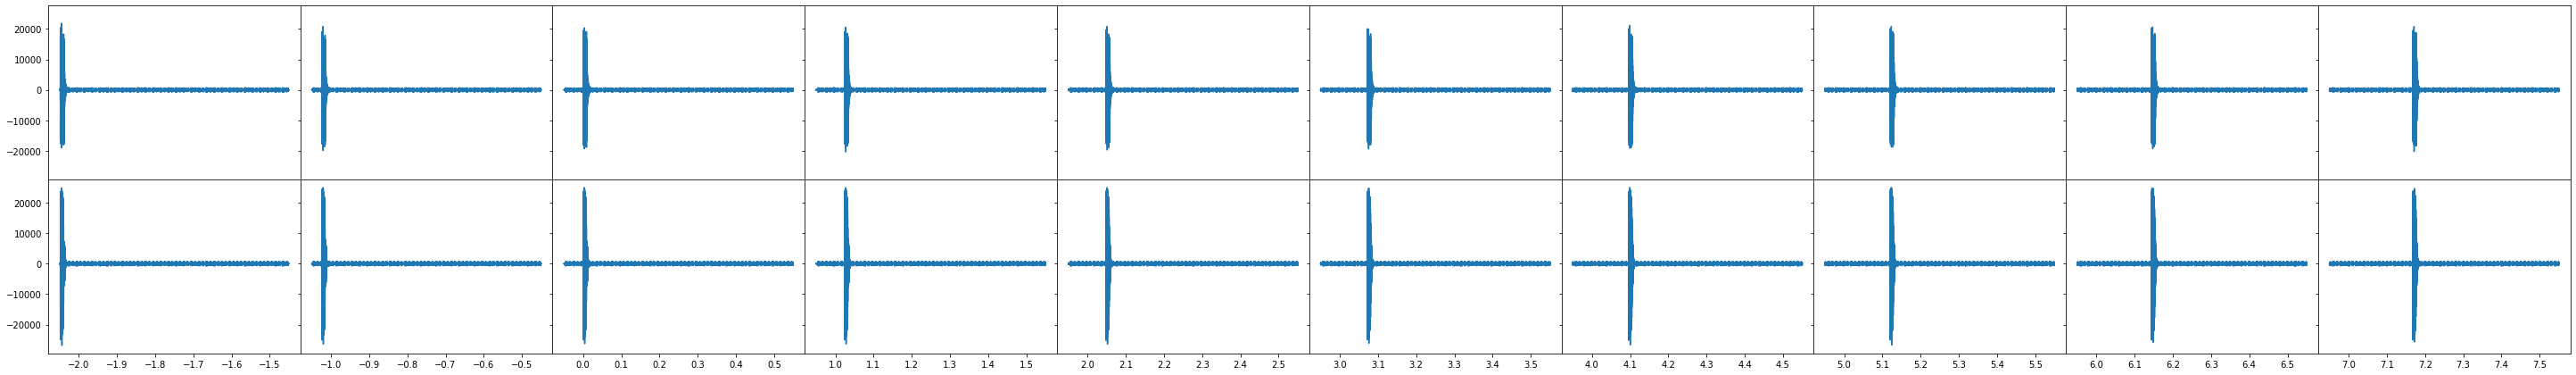

In [ ]:
bp_args={'fs': fs, 'low': 20e3, 'high': 50e3}
bp = BP(**bp_args)
get_win = lambda i: slice(int(fs*(i+0.25)), int(fs*(i+0.85)))
f, axs = plt.subplots(2, 10, sharex='col', sharey=True, figsize=(40,6))
f.tight_layout()
for i, ax in enumerate(zip(*axs)):
    win = get_win(i)
    ax[0].plot(bt[win], bp(bdata[win,0]))
    ax[1].plot(bt[win], bp(bdata[win,1]))
f.subplots_adjust(wspace=0, hspace=0)

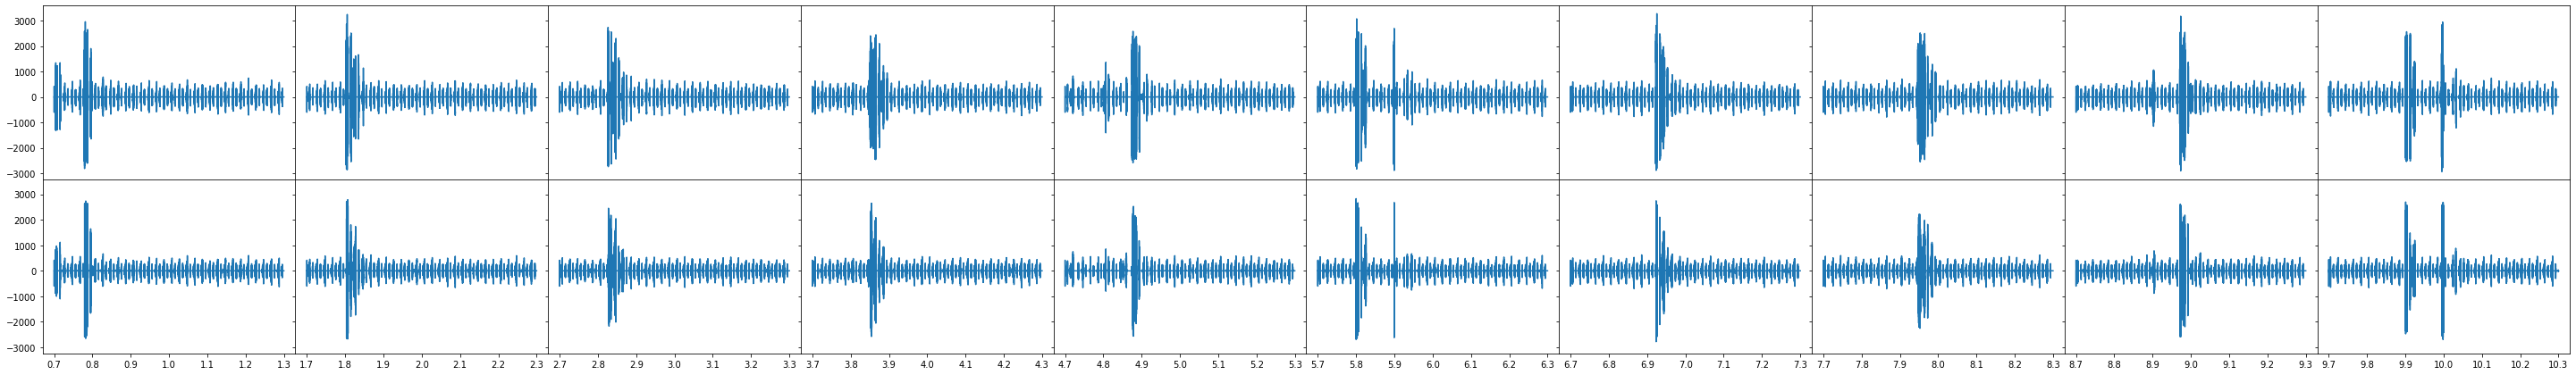

In [ ]:
bp_args={'fs': fs, 'low': 20e3, 'high': 50e3}
bp = BP(**bp_args)
get_win = lambda i: slice(int(fs*(i+0.7)), int(fs*(i+1.3)))
f, axs = plt.subplots(2, 10, sharex='col', sharey=True, figsize=(40,6))
f.tight_layout()
for i, ax in enumerate(zip(*axs)):
    win = get_win(i)
    ax[0].plot(t[win], bp(y[win,0]))
    ax[1].plot(t[win], bp(y[win,1]))
f.subplots_adjust(wspace=0, hspace=0)

### 35->40

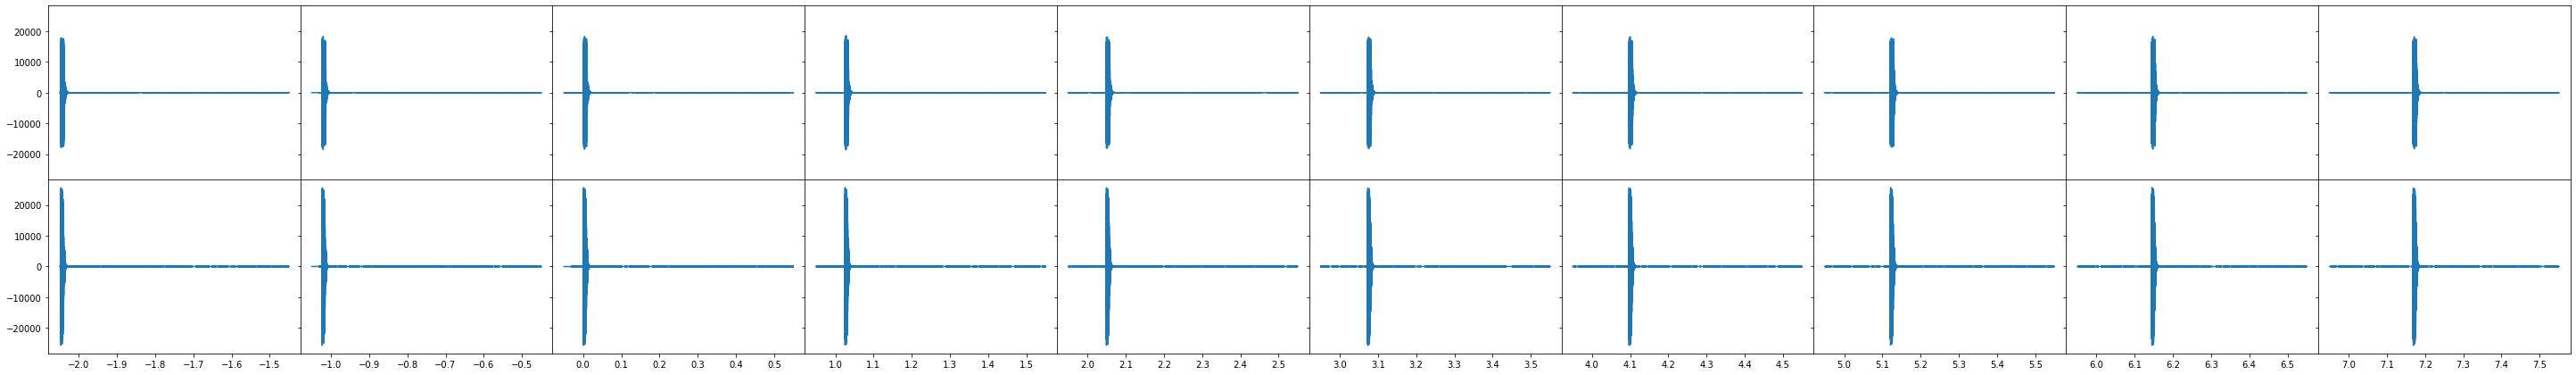

In [ ]:
bp_args={'fs': fs, 'low': 35e3, 'high': 40e3}
bp = BP(**bp_args)
get_win = lambda i: slice(int(fs*(i+0.25)), int(fs*(i+0.85)))
f, axs = plt.subplots(2, 10, sharex='col', sharey=True, figsize=(40,6))
f.tight_layout()
for i, ax in enumerate(zip(*axs)):
    win = get_win(i)
    ax[0].plot(bt[win], bp(bdata[win,0]))
    ax[1].plot(bt[win], bp(bdata[win,1]))
f.subplots_adjust(wspace=0, hspace=0)

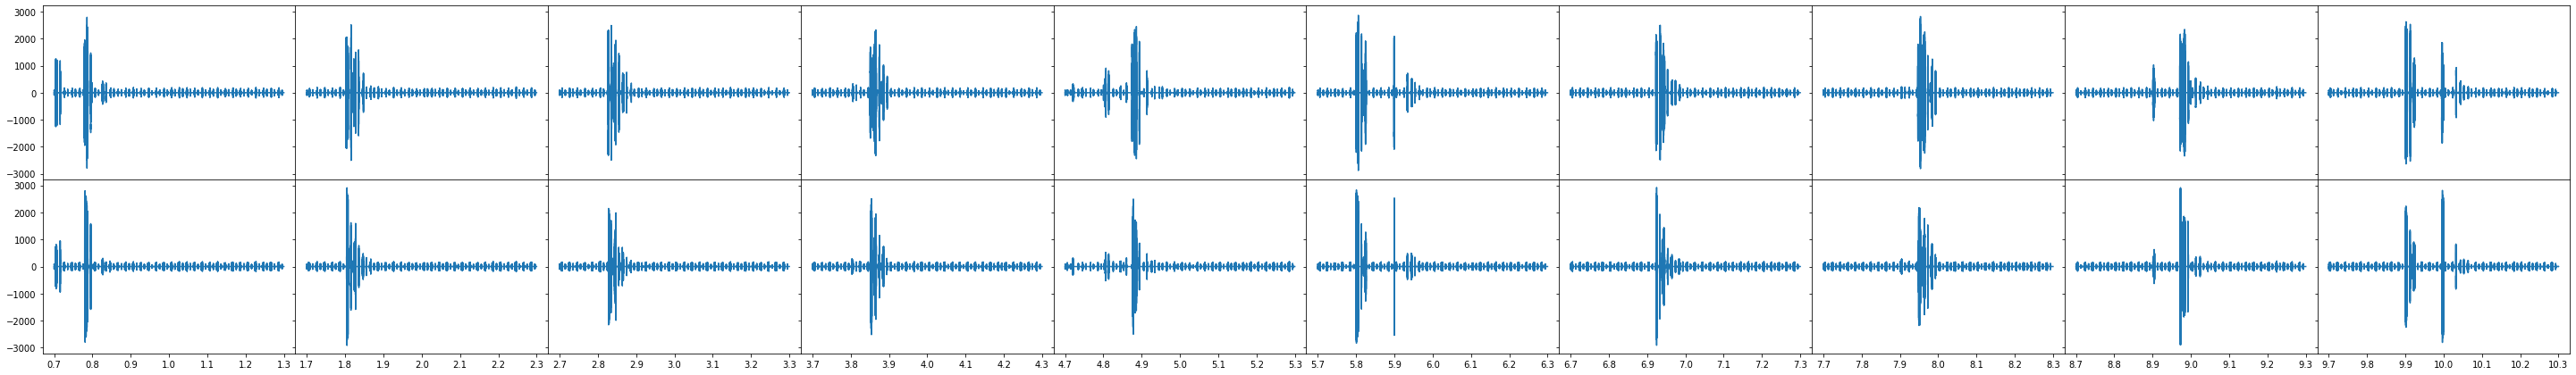

In [ ]:
bp_args={'fs': fs, 'low': 35e3, 'high':40e3}
bp = BP(**bp_args)
get_win = lambda i: slice(int(fs*(i+0.7)), int(fs*(i+1.3)))
f, axs = plt.subplots(2, 10, sharex='col', sharey=True, figsize=(40,6))
f.tight_layout()
for i, ax in enumerate(zip(*axs)):
    win = get_win(i)
    ax[0].plot(t[win], bp(y[win,0]))
    ax[1].plot(t[win], bp(y[win,1]))
f.subplots_adjust(wspace=0, hspace=0)

## With Zero Crossing

In [ ]:
def view_pings(bt, bdata, start=0.25):
    bp_args={'fs': fs, 'low': 35e3, 'high': 40e3}
    bp = BP(**bp_args)
    get_win = lambda i: slice(int(fs*(i+start)), int(fs*(i+start + 0.6)))
    f, axs = plt.subplots(2, 10, sharex='col', sharey=True, figsize=(40,6))
    f.tight_layout()
    for i, ax in enumerate(zip(*axs)):
        win = get_win(i)
        d = bp(bdata[win,0])
        ax[0].plot(bt[win], d)
        index = Est_ZC_stage_1(d, int(0.004 * fs), 200, run_plot=False)
        if index !=0:
            ax[0].axvline(x=bt[win][index], color='red', alpha=0.6, linewidth=2)
        
        d = bp(bdata[win,1])
        ax[1].plot(bt[win], d)
        index2 = Est_ZC_stage_1(d, int(0.004 * fs), 200, run_plot=False)
        if index2 !=0:
            ax[1].axvline(x=bt[win][index2], color='red', alpha=0.6, linewidth=2)
        
        if index != 0 and index2 != 0:
            print((index2 - index) * v_sound / fs, end=' ')
        else:
            print(np.nan, end=' ')

    f.subplots_adjust(wspace=0, hspace=0)

0.01184 0.01184 0.01184 0.01036 -0.0666 0.01184 0.01184 0.01036 0.01184 0.01036 

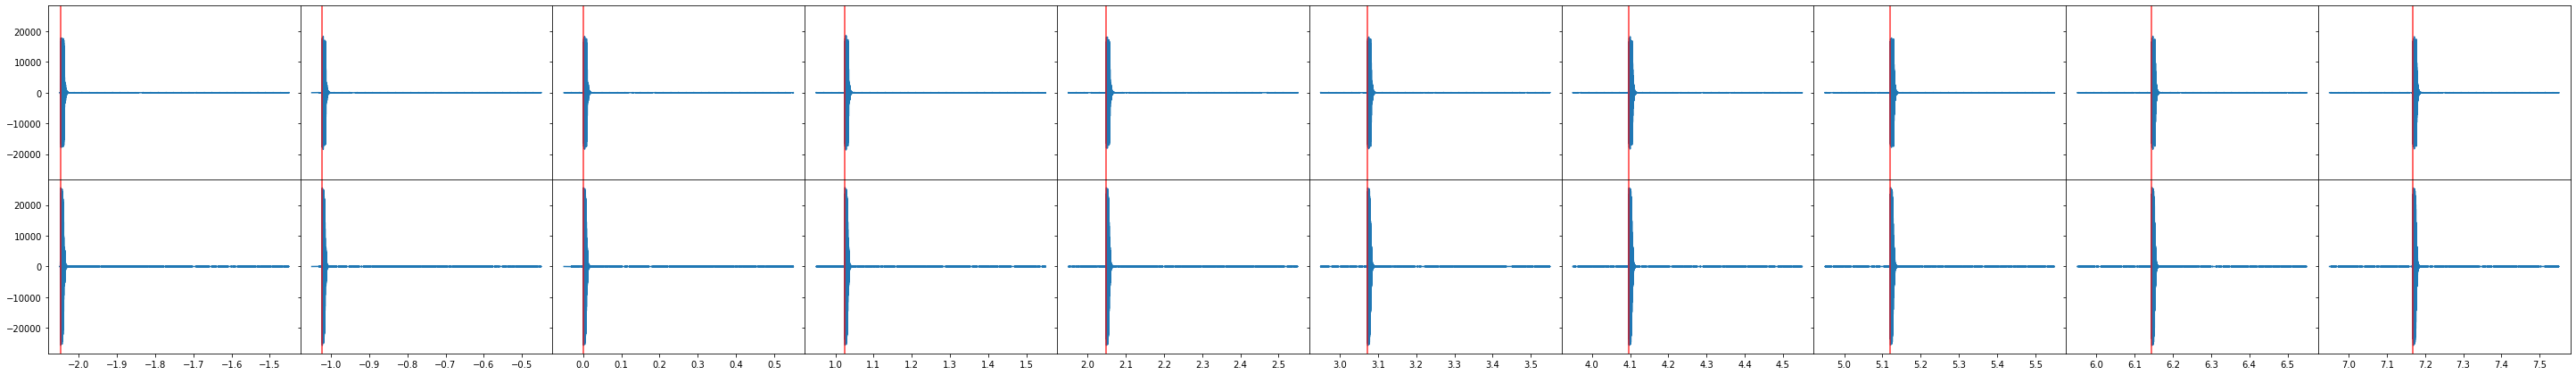

In [ ]:
view_pings(bt, bdata)

1.38084 1.26392 1.4208 1.94028 2.13564 0.0888 1.49628 2.53672 1.5022 -0.50468 

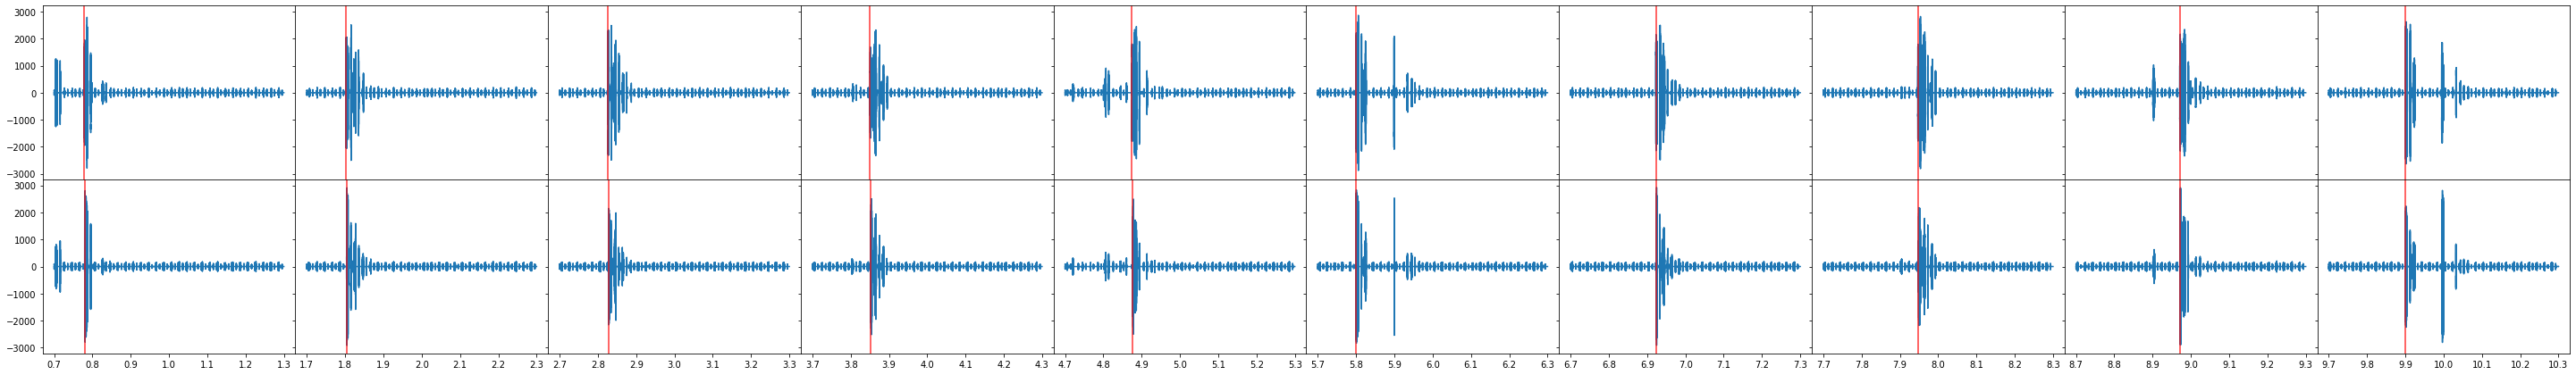

In [ ]:
view_pings(*data_loader[0.65, 0], start=0.7)

1.66056 -2.02168 1.46076 1.4208 1.38084 0.27232 1.46076 1.46076 1.38232 -0.10656 

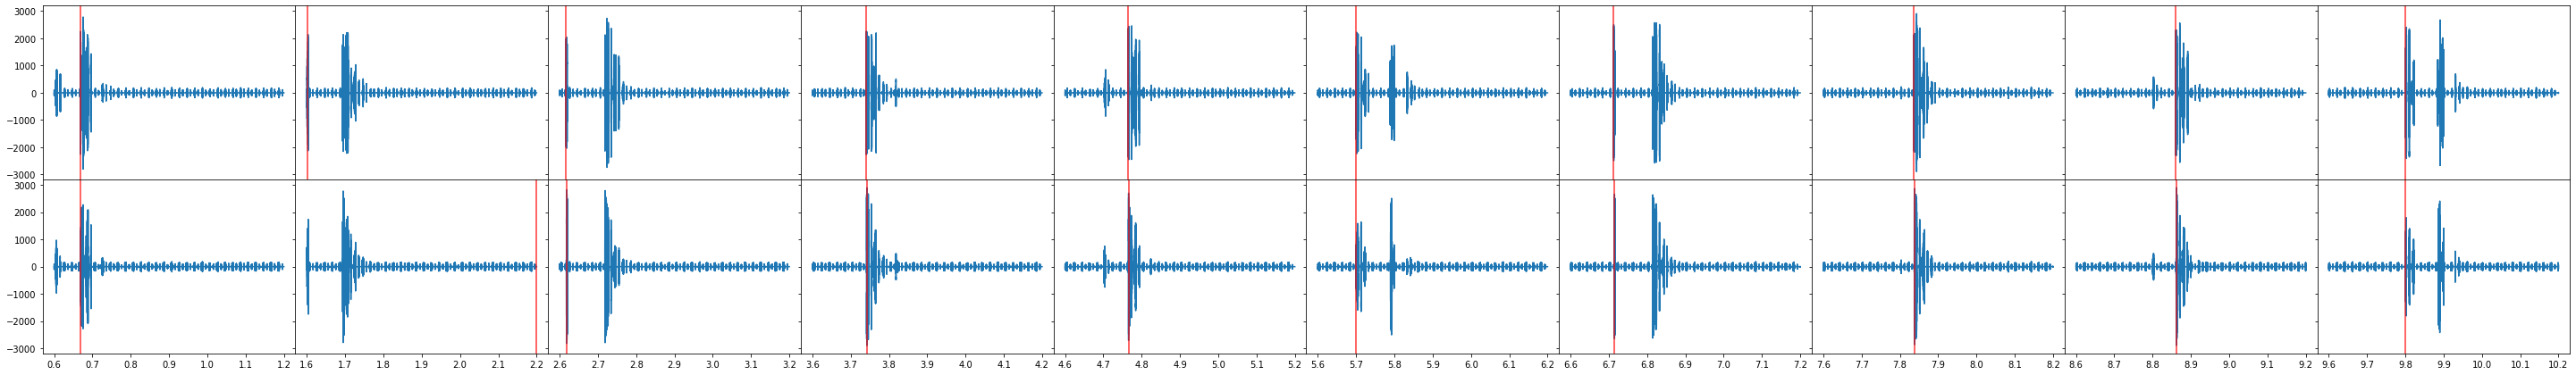

In [ ]:
view_pings(*data_loader[0.65, 1], start=0.6)

0.39664 -4.25796 -0.37296 -0.65416 0.20424 0.2442 -6.35512 -1.45484 0.27972 0.24272 

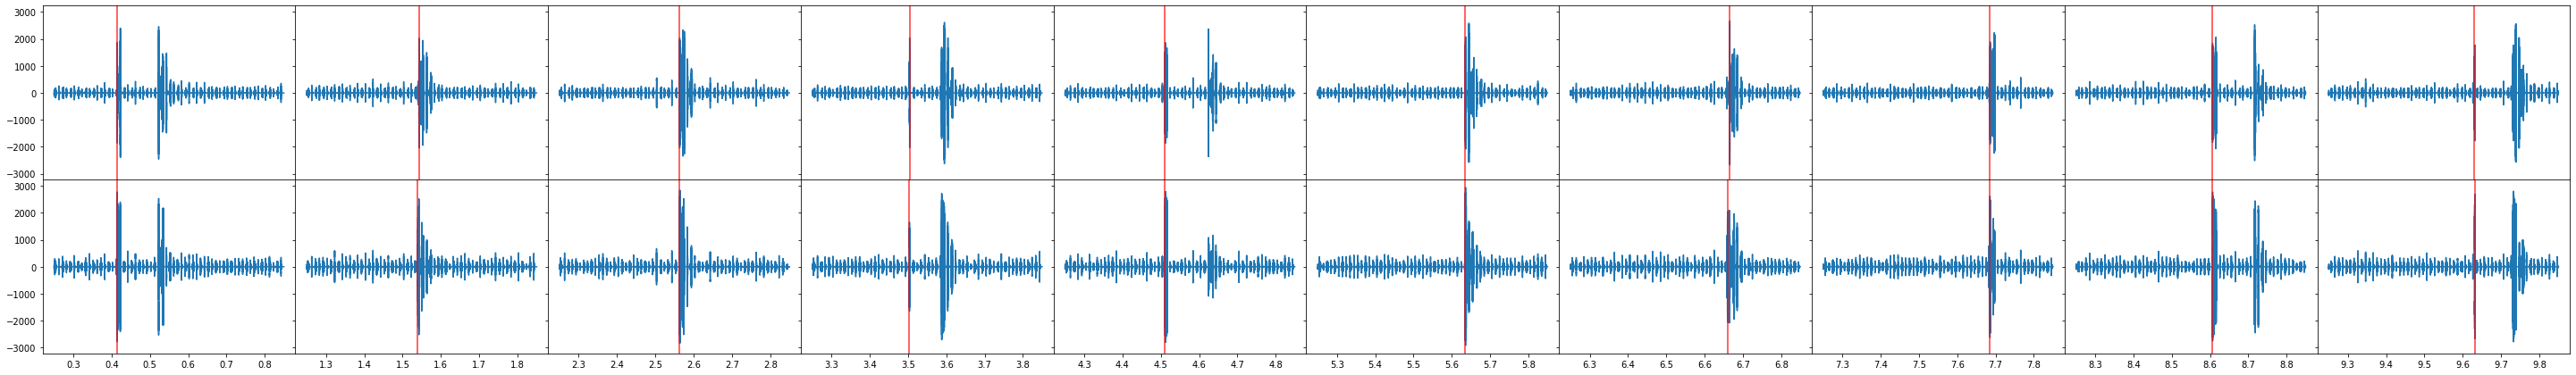

In [ ]:
view_pings(*data_loader[0.00, 0], start=0.25)

-6.02064 1.03304 0.67784 0.46028 1.98616 1.40896 0.55944 0.55944 0.21312 15.45564 

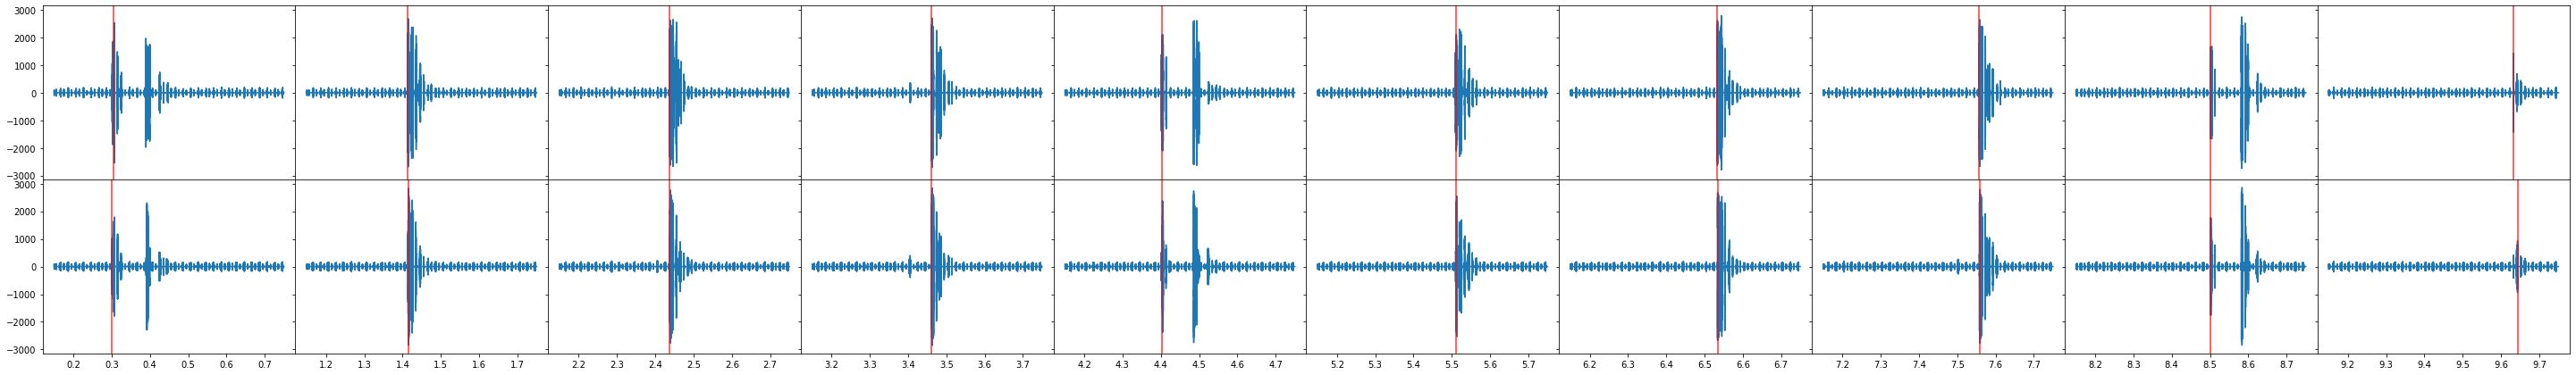

In [ ]:
view_pings(*data_loader[0.00, 1], start=0.15)

4.21208 -0.24124 154.512 4.13068 4.45332 4.21208 3.00736 4.61168 4.49624 3.40548 

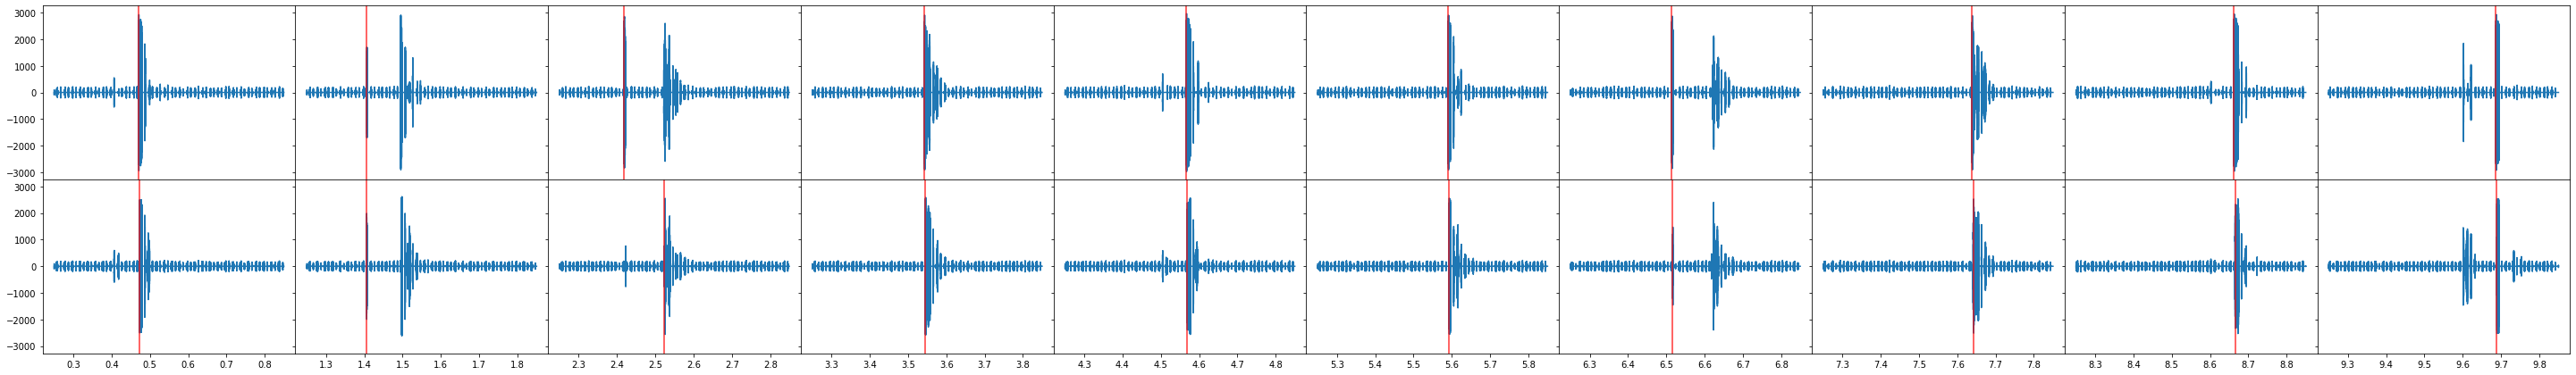

In [ ]:
view_pings(*data_loader[1.25, 0], start=0.25)

-111.75924 208.84428 8.5544 2.92744 4.255 -0.29156 3.04732 8.95696 3.16424 0.26048 

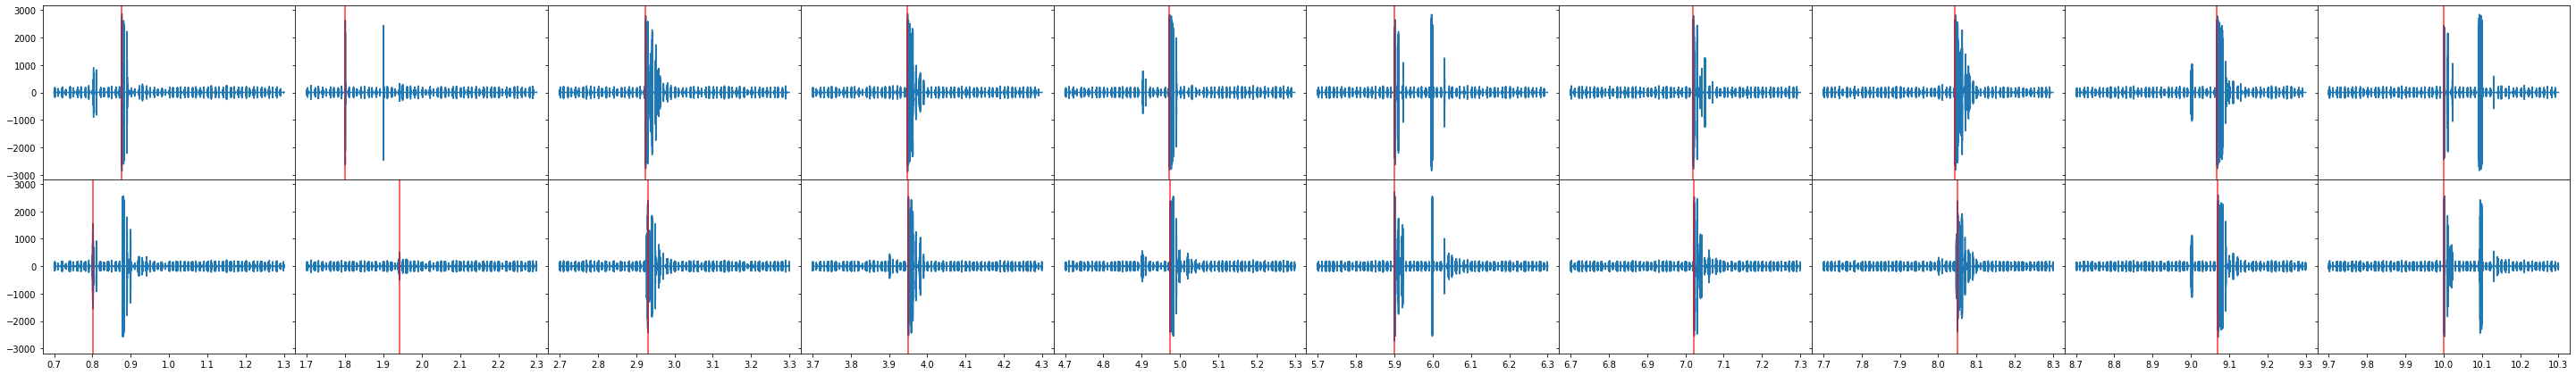

In [ ]:
view_pings(*data_loader[1.25, 1], start=0.7)

# Figure out Double Signal

d000_2:   0%|          | 0/507 [00:00<?, ?it/s]

Got 506 chunks of 507 expected


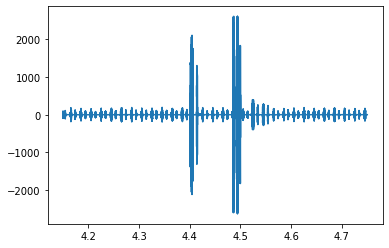

In [ ]:
t, y = data_loader[0.00, 1]
win = slice(int(fs*4.15), int(fs*4.75))
tt = t[win]
yy = y[win, 0]
plt.plot(tt, BP(**{'fs': fs, 'low': 35e3, 'high': 40e3})(yy))

In [ ]:
import pywt

In [ ]:
scale = np.linspace(5,5000, 50)
f = pywt.scale2frequency('mexh', scale)/dt
f[-1], f[0]

(50.00000000000001, 50000.00000000001)

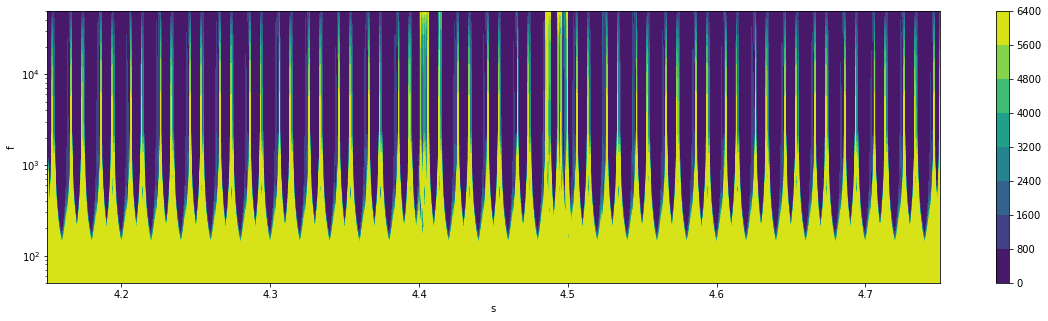

In [ ]:
coef, freqs=pywt.cwt(yy,scale, 'mexh', sampling_period=dt, method='fft')

plt.figure(figsize=(20,5))
plt.contourf(tt, freqs, np.clip(np.abs(coef), 0, 6000))
plt.xlabel('s')
plt.ylabel('f')
plt.gca().set_yscale('log')
plt.colorbar()

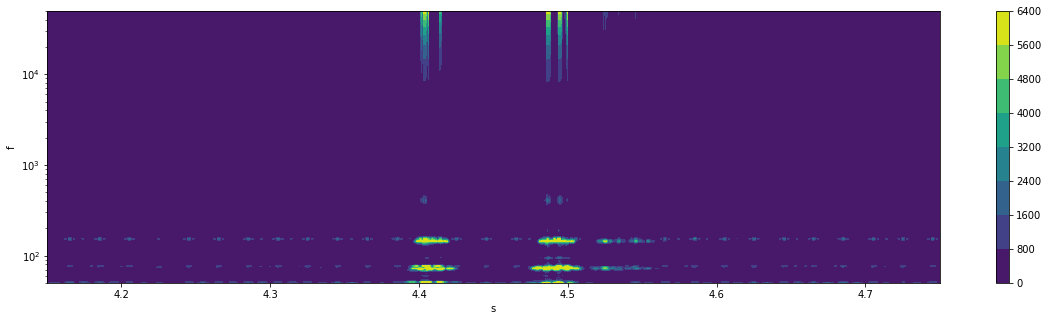

In [ ]:
coef, freqs=pywt.cwt(BP(**{'fs': fs, 'low': 35e3, 'high': 40e3})(yy), scale, 'mexh', sampling_period=dt, method='fft')

plt.figure(figsize=(20,5))
plt.contourf(tt, freqs, np.clip(np.abs(coef), 0, 6000))
plt.xlabel('s')
plt.ylabel('f')
plt.gca().set_yscale('log')
plt.colorbar()

**Both real/fake pings both look like they have the same signature, nothing really defining is different**

In [ ]:
!free -h

              total        used        free      shared  buff/cache   available
Mem:            12G        4.4G        7.1G        1.2M        1.2G        9.3G
Swap:            0B          0B          0B


# Compare with Amit Daud Data

## Get Data

In [ ]:
url = 'https://drive.google.com/file/d/1JV2K3AqffI_EtBXOr2ojJaVxdZw8FO9i/view?usp=sharing'
filename = 'old_amit_data_sample.csv'

In [ ]:
!ls "{filename}" 2>/dev/null || (python -m pip install gdown --upgrade > /dev/null && gdown --fuzzy "{url}")

Downloading...
From: https://drive.google.com/uc?id=1JV2K3AqffI_EtBXOr2ojJaVxdZw8FO9i
To: /content/old_amit_data_sample.csv
100% 15.9M/15.9M [00:00<00:00, 73.1MB/s]


In [ ]:
adata = np.loadtxt(filename)
at = np.arange(adata.shape[0]) * dt

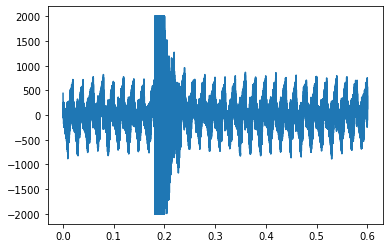

In [ ]:
plt.plot(at, adata)

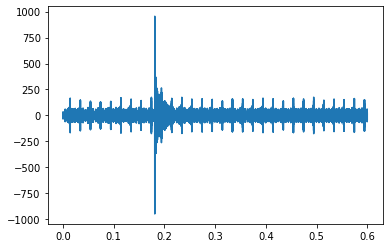

In [ ]:
plt.plot(at, BP(**{'fs': fs, 'low': 35e3, 'high': 40e3})(adata))